In [1]:
%load_ext google.cloud.bigquery

In [2]:
import os
from google.cloud.bigquery.client import Client

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'C:\\Users\\Francesco\\fiery-rarity-322109-6ba6fa8a811c.json' #service-account-file.json
bq_client = Client()

In [41]:
%%bigquery RV --project charged-sector-315517

with
--contracts as (select distinct address from `bigquery-public-data.crypto_ethereum.contracts`),
double_entry_book as (
    -- debits
    select to_address as address, value as value, block_timestamp
    from `bigquery-public-data.crypto_ethereum.traces`
    where to_address is not null
    and status = 1
    and (call_type not in ('delegatecall', 'callcode', 'staticcall') or call_type is null)--and trace_type not in ('genesis', 'reward'))
    and DATE(block_timestamp) <= "2021-08-01"
    union all
    -- transaction fees credits
    select from_address as address, cast(receipt_gas_used as numeric) * cast(gas_price as numeric) as value, block_timestamp
    from `bigquery-public-data.crypto_ethereum.transactions`
    where DATE(block_timestamp) <= "2021-08-01"
)
,double_entry_book_by_date as (
    select 
        date(block_timestamp) as date, 
        t1.address, 
        sum(t1.value / 1e18 * case when t2.close is null then 3 else t2.close end) value_usd
    -- TODO: compute value in USD
    from double_entry_book t1
    left join `charged-sector-315517.eth.eth_usd_hist_min` t2 on DATETIME_TRUNC(t1.block_timestamp, MINUTE) = TIMESTAMP_SECONDS(t2.time)
    --left join contracts t3 on t1.address = t3.address
    --where t3.address is null
    group by date, t1.address
)
,daily_balances_with_gaps as (
    select 
        address, 
        date,
        sum(value_usd) over (partition by address order by date) as balance,
        lead(date, 1, "2021-08-01") over (partition by address order by date) as next_date
        from double_entry_book_by_date
)
,calendar as (
    select date from unnest(generate_date_array("2015-07-30", "2021-08-01")) as date
)
,daily_balances as (
    select address, calendar.date, balance
    from daily_balances_with_gaps
    join calendar on daily_balances_with_gaps.date <= calendar.date and calendar.date < daily_balances_with_gaps.next_date
)
select date, sum(balance) RV
from daily_balances
group by date
order by date

Downloading: 100%|██████████| 2194/2194 [00:02<00:00, 773.75rows/s] 


<AxesSubplot:>

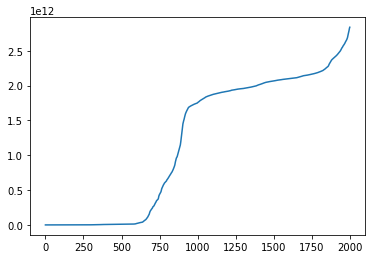

In [42]:
RV['RV'].plot()

In [43]:
%%bigquery supply --project charged-sector-315517

with ether_emitted_by_date  as (
  select date(block_timestamp) as date, sum(value) as value
  from `bigquery-public-data.crypto_ethereum.traces`
  where trace_type in ('genesis', 'reward')
  group by date(block_timestamp)
)
select date, sum(value) OVER (ORDER BY date) / 1e18 AS supply
from ether_emitted_by_date

Downloading: 100%|██████████| 2199/2199 [00:02<00:00, 866.80rows/s]


<AxesSubplot:>

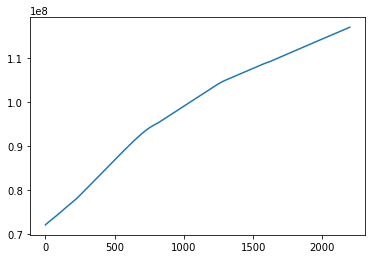

In [56]:
supply['supply'].astype('float').plot() #[supply['supply'].isnull()]#

In [19]:
%%bigquery close --project charged-sector-315517
select close from `charged-sector-315517.eth.eth_usd_hist_min` order by time

Downloading: 100%|██████████| 3148437/3148437 [00:11<00:00, 276900.13rows/s]


<AxesSubplot:>

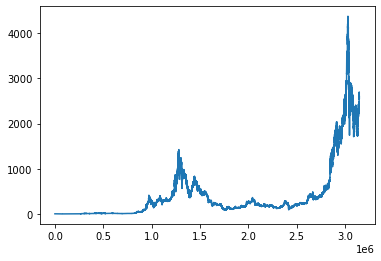

In [20]:
close['close'].plot()

In [76]:
%%bigquery price_daily --project charged-sector-315517

SELECT  date(TIMESTAMP_SECONDS(time)) date, close
FROM `charged-sector-315517.eth.eth_usd_hist_min`
where TIMESTAMP_SECONDS(time) = TIMESTAMP_TRUNC(TIMESTAMP_SECONDS(time), DAY)
order by date

Downloading: 100%|██████████| 2186/2186 [00:02<00:00, 884.45rows/s] 


<AxesSubplot:>

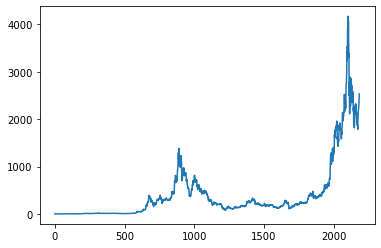

In [77]:
price_daily['close'].plot()

In [78]:
%%bigquery price_hourly --project charged-sector-315517

SELECT  TIMESTAMP_TRUNC(TIMESTAMP_SECONDS(time), HOUR) date, close
FROM `charged-sector-315517.eth.eth_usd_hist_min`
where TIMESTAMP_SECONDS(time) = TIMESTAMP_TRUNC(TIMESTAMP_SECONDS(time), HOUR)
order by date

Downloading: 100%|██████████| 52473/52473 [00:03<00:00, 15287.62rows/s]


<AxesSubplot:>

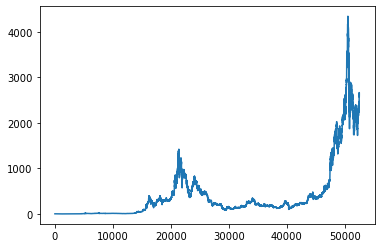

In [79]:
price_hourly['close'].plot()

In [82]:
%%bigquery eth_gini --project charged-sector-315517

with
--price as (
--    SELECT  date(TIMESTAMP_SECONDS(time)) date, close price
--    FROM `charged-sector-315517.eth.eth_usd_hist_min`
--    where TIMESTAMP_SECONDS(time) = TIMESTAMP_TRUNC(TIMESTAMP_SECONDS(time), DAY)
--),
double_entry_book as (
    -- debits
    select to_address as address, value as value, block_timestamp
    from `bigquery-public-data.crypto_ethereum.traces`
    where to_address is not null
    and status = 1
    and call_type not in ('delegatecall', 'callcode', 'staticcall') --or call_type is null)
    and DATE(block_timestamp) <= "2021-08-01"
    union all
    -- credits
    select from_address as address, -value as value, block_timestamp
    from `bigquery-public-data.crypto_ethereum.traces`
    where from_address is not null
    and status = 1
    and call_type not in ('delegatecall', 'callcode', 'staticcall') --or call_type is null)
    and DATE(block_timestamp) <= "2021-08-01"
    union all
    -- transaction fees debits
    select miner as address, sum(cast(receipt_gas_used as numeric) * cast(gas_price as numeric)) as value, block_timestamp
    from `bigquery-public-data.crypto_ethereum.transactions` as transactions
    join `bigquery-public-data.crypto_ethereum.blocks` as blocks on blocks.number = transactions.block_number
    where DATE(transactions.block_timestamp) <= "2021-08-01"
    group by blocks.miner, block_timestamp
    union all
    -- transaction fees credits
    select from_address as address, -(cast(receipt_gas_used as numeric) * cast(gas_price as numeric)) as value, block_timestamp
    from `bigquery-public-data.crypto_ethereum.transactions`
    where DATE(block_timestamp) <= "2021-08-01"
)
,double_entry_book_by_date as (
    select 
        date(block_timestamp) as date, 
        address, 
        sum(value) as value
    from double_entry_book
    group by date, address
)
,daily_balances_with_gaps as (
    select 
        address, 
        date,
        sum(value) over (partition by address order by date) as balance,
        lead(date, 1, "2021-08-01") over (partition by address order by date) as next_date
        from double_entry_book_by_date
)
,calendar as (
    select date from unnest(generate_date_array("2015-07-30", "2021-08-01")) as date
)
,daily_balances as (
    select address, calendar.date, balance / 1e18 as balance  #* price
    from daily_balances_with_gaps
    --join price on daily_balances_with_gaps.date = price.date
    join calendar on daily_balances_with_gaps.date <= calendar.date and calendar.date < daily_balances_with_gaps.next_date
)
,supply as (
    select
        date,
        sum(balance) as daily_supply
    from daily_balances
    group by date
)
,ranked_daily_balances as (
    select 
        daily_balances.date,
        balance,
        row_number() over (partition by daily_balances.date order by balance desc) as rank
    from daily_balances
    join supply on daily_balances.date = supply.date
    where safe_divide(balance, daily_supply) >= 0.0001
    ORDER BY safe_divide(balance, daily_supply) DESC
)

select 
    date, 
    -- (1 − 2B) https://en.wikipedia.org/wiki/Gini_coefficient
    1 - 2 * sum((balance * (rank - 1) + balance / 2)) / count(*) / sum(balance) as gini
from ranked_daily_balances
group by date
order by date asc

Downloading: 100%|██████████| 2186/2186 [00:02<00:00, 793.20rows/s] 


In [ ]:
eth_gini['gini'].plot()

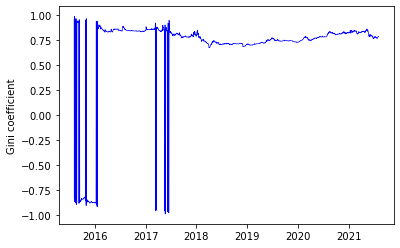

In [67]:
import matplotlib.pyplot as plt

plt.plot(eth_gini['date'], eth_gini['gini'], 'b-', label = "", linewidth = .7)
plt.ylabel('Gini coefficient')
plt.show()

In [100]:
%%bigquery nr_transactions --project charged-sector-315517

select DATE(block_timestamp) date, count(*) count
from `bigquery-public-data.crypto_ethereum.transactions`
where (receipt_status = 1 or receipt_status is null) --and value > 0
group by date
order by date

Downloading: 100%|██████████| 2191/2191 [00:02<00:00, 751.87rows/s]


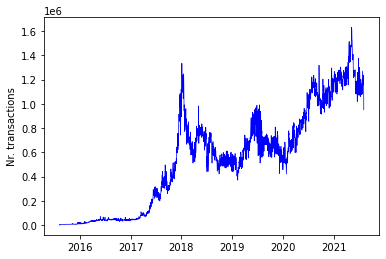

In [101]:
import matplotlib.pyplot as plt

plt.plot(nr_transactions['date'], nr_transactions['count'], 'b-', label = "", linewidth = .7)
plt.ylabel('Nr. transactions')
plt.show()

In [104]:
%%bigquery nr_int_transactions --project charged-sector-315517

with
contracts as (
    select address, min(block_number) block_number from `bigquery-public-data.crypto_ethereum.contracts` group by address
)
SELECT DATE(t1.block_timestamp) date
, sum(case when t2.block_timestamp is not null and t3.address is null then 1 else 0 end) transaction_address
, sum(case when t2.block_timestamp is not null and t3.address is not null then 1 else 0 end) transaction_contract
, sum(case when t2.block_timestamp is null and t3.address is null then 1 else 0 end) int_transaction_address
, sum(case when t2.block_timestamp is null and t3.address is not null then 1 else 0 end) int_transaction_contract
FROM `bigquery-public-data.crypto_ethereum.traces` t1
left join `bigquery-public-data.crypto_ethereum.transactions` t2 using (block_timestamp, from_address, to_address, value)
left join contracts t3 on t1.to_address = t3.address and t1.block_number >= t3.block_number
WHERE t1.status = 1 and t1.call_type = 'call' and t1.value > 0
group by date
order by date


Downloading: 100%|██████████| 2191/2191 [00:03<00:00, 721.13rows/s]


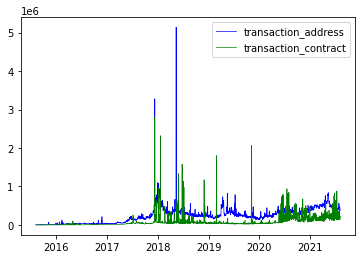

In [105]:
plt.plot(nr_int_transactions['date'], nr_int_transactions['transaction_address'], 'b-', label = "transaction_address", linewidth = .7)
plt.plot(nr_int_transactions['date'], nr_int_transactions['transaction_contract'], 'g-', label = "transaction_contract", linewidth = .7)
plt.legend()
plt.show()

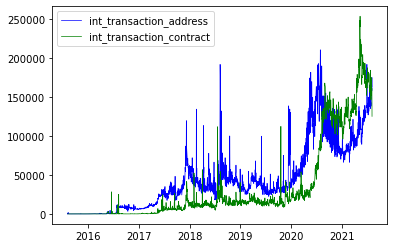

In [106]:
plt.plot(nr_int_transactions['date'], nr_int_transactions['int_transaction_address'], 'b-', label = "int_transaction_address", linewidth = .7)
plt.plot(nr_int_transactions['date'], nr_int_transactions['int_transaction_contract'], 'g-', label = "int_transaction_contract", linewidth = .7)
plt.legend()
plt.show()

# :::::::::::::::::::::::::: Charts ::::::::::::::::::::::::::

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# set seaborn plotting theme
sns.set_theme()

# set colour palette
pal = ['#00388F', '#FFB400', '#FF4B00', '#65B800']

## Price

In [ ]:
%%bigquery price_hourly --project charged-sector-315517

SELECT  TIMESTAMP_TRUNC(TIMESTAMP_SECONDS(time), HOUR) date, close
FROM `charged-sector-315517.eth.eth_usd_hist_min`
where TIMESTAMP_SECONDS(time) = TIMESTAMP_TRUNC(TIMESTAMP_SECONDS(time), HOUR)
order by date

## Nr of transactions

In [ ]:
%%bigquery nr_int_transactions --project charged-sector-315517

with
contracts as (
    select address, min(block_number) block_number from `bigquery-public-data.crypto_ethereum.contracts` group by address
)
SELECT DATE(t1.block_timestamp) date
, sum(case when t2.block_timestamp is not null and t3.address is null then 1 else 0 end) transaction_address
, sum(case when t2.block_timestamp is not null and t3.address is not null then 1 else 0 end) transaction_contract
, sum(case when t2.block_timestamp is null and t3.address is null then 1 else 0 end) int_transaction_address
, sum(case when t2.block_timestamp is null and t3.address is not null then 1 else 0 end) int_transaction_contract
FROM `bigquery-public-data.crypto_ethereum.traces` t1
left join `bigquery-public-data.crypto_ethereum.transactions` t2 using (block_timestamp, from_address, to_address, value)
left join contracts t3 on t1.to_address = t3.address and t1.block_number >= t3.block_number
WHERE t1.status = 1 and t1.call_type = 'call' and t1.value > 0 and date(t1.block_timestamp) <= '2021-07-30'
group by date
order by date

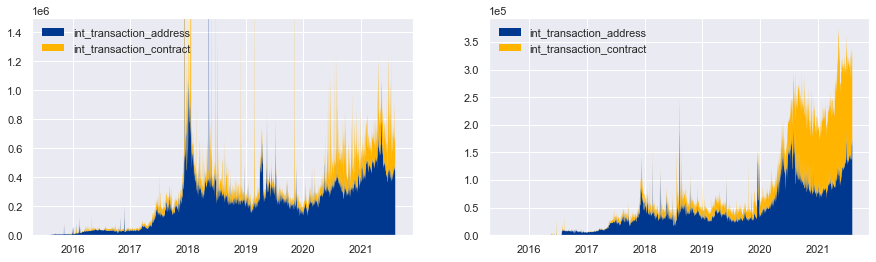

In [162]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

x = nr_int_transactions['date']
y1, y2 = nr_int_transactions['transaction_address'], nr_int_transactions['transaction_contract']

#ax[0].get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
ax[0].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax[0].stackplot(x, y1, y2, labels = ['int_transaction_address', 'int_transaction_contract'], colors = pal, linewidth = 0)
ax[0].legend(loc = 'upper left', frameon = False)
ax[0].set_ylim(ymax = 1.5e6)

y1, y2 = nr_int_transactions['int_transaction_address'], nr_int_transactions['int_transaction_contract']

#ax[1].get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
ax[1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax[1].stackplot(x, y1, y2, labels = ['int_transaction_address', 'int_transaction_contract'], colors = pal, linewidth = 0)
ax[1].legend(loc = 'upper left', frameon = False)

(0.0, 1500000.0)

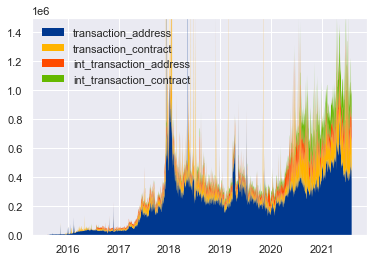

In [160]:
x = nr_int_transactions['date']
y1, y2, y3, y4 = nr_int_transactions['transaction_address'], nr_int_transactions['transaction_contract'], nr_int_transactions['int_transaction_address'], nr_int_transactions['int_transaction_contract']

plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.stackplot(x, y1, y2, y3, y4, labels = ['transaction_address', 'transaction_contract', 'int_transaction_address', 'int_transaction_contract'], colors = pal, linewidth = 0)
plt.legend(loc = 'upper left', frameon = False)
plt.ylim(ymax = 1.5e6)

## Supply

In [13]:
%%bigquery supply --project fiery-rarity-322109

with ether_emitted_by_date  as (
  select TIMESTAMP_TRUNC(block_timestamp, HOUR) as date
  , sum(case when trace_type = 'genesis' then value else 0 end) as value_genesis
  , sum(case when trace_type = 'reward' then value else 0 end) as value_reward
  from `bigquery-public-data.crypto_ethereum.traces`
  where trace_type in ('genesis', 'reward') and status = 1 and date(block_timestamp) <= '2021-07-30'
  group by date
)
select case when date(date) < '2015-07-30' then CAST('2015-07-30' AS TIMESTAMP) else date end as date
, sum(value_genesis) OVER (ORDER BY date) / power(10, 18) AS supply_genesis
, sum(value_reward) OVER (ORDER BY date) / power(10, 18) AS supply_reward
from ether_emitted_by_date

Downloading: 100%|██████████| 52615/52615 [00:03<00:00, 16898.85rows/s]


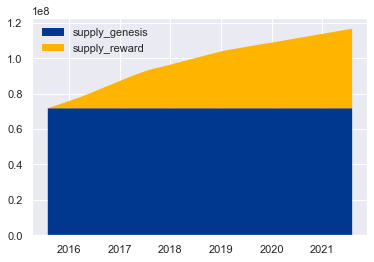

In [16]:
x = supply['date']
y1, y2 = supply['supply_genesis'], supply['supply_reward']

plt.ticklabel_format(axis = "y", style = "sci", scilimits = (0,0))
plt.stackplot(x, y1, y2, labels = ['supply_genesis', 'supply_reward'], colors = pal, linewidth = 0)
plt.legend(loc = 'upper left', frameon = False)
plt.show()

In [3]:
%%bigquery market_data --project fiery-rarity-322109

SELECT  TIMESTAMP_TRUNC(TIMESTAMP_SECONDS(time), HOUR) as date, close, volumeto as volume
FROM `fiery-rarity-322109.ethereum.eth_usd_min`
where TIMESTAMP_SECONDS(time) = TIMESTAMP_TRUNC(TIMESTAMP_SECONDS(time), HOUR) and DATE(TIMESTAMP_SECONDS(time)) <= '2021-07-30'
order by date

Downloading: 100%|██████████| 10/10 [00:02<00:00,  3.47rows/s]


In [ ]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(market_data["date"], market_data["close"], 'g-', label = "USD price", linewidth = .7)
ax2.fill_between(market_data["date"], market_data["volume"], 'b-', label = "USD volume", linewidth = .7)
ax1.set_ylabel('Nr. daily transactions', color='g')
ax2.set_ylabel('Daily value, Ether', color='b')
# plt.legend()
plt.show()